# NV Center in Diamond
In this tutorial we will go over the main steps of running CCE calculations for NV center in diamond with `pycce` module. Those include:

* Generating spin bath using `pycce.BathCell` instance.
* Setting up properties of the `pycce.Simulator` instance.
* Running the calculations with `Simulator.compute` function.

We will compute Hahn-echo coherence function (with decoupling $\pi$-pulse applied) using all three available methods: 

* Conventional CCE.
* Generalized CCE (gCCE).
* gCCE with Monte-Carlo bath sampling.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('/home/onizhuk/midway/codes_development/pyCCE')
import pycce as pc
import ase

from mpl_toolkits import mplot3d

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

## Generate nuclear spin bath
Building a supercell of nuclear spins from the `ase.Atoms` object..

### Build BathCell

To do it from `ase.atoms` object, use classmethod `BathCell.from_ase`.

In [3]:
from ase.build import bulk

# Generate unitcell from ase
diamond = bulk('C', 'diamond', cubic=True)
diamond = pc.bath.BathCell.from_ase(diamond)

The following attributes created with this initiallization:

* `.cell` is ndarray containing information of lattice vectors. Each **column** is a lattice vector in the cartesian coordinates.
* `.atoms` is a dictionary with keys corresponding to the atom name, and each item is a list of the coordinates in cell coordinates.

In [4]:
print('Cell\n', diamond.cell)
print('\nAtoms\n', diamond.atoms)

Cell
 [[3.57 0.   0.  ]
 [0.   3.57 0.  ]
 [0.   0.   3.57]]

Atoms
 defaultdict(<class 'list'>, {'C': [array([0., 0., 0.]), array([0.25, 0.25, 0.25]), array([0. , 0.5, 0.5]), array([0.25, 0.75, 0.75]), array([0.5, 0. , 0.5]), array([0.75, 0.25, 0.75]), array([0.5, 0.5, 0. ]), array([0.75, 0.75, 0.25])]})


### Populate BathCell with isotopes

The **pycce** package uses EasySpin database of the concentrations of all common stable isotopes with non-zero spin, however user can proide custom concentrations.


Use function `BathCell.add_isotopes` to add one (or several) isotopes of the element with tuples containing name of the isotope and it's concentration. 
Name of the isotope includes number and element symbol, provided in the `atoms` object. Returns dictionary `BathCell.isotopes` which can be modified directly. Structure of the dictionary-like object:

```
{element_1: {isotope_1: concentration, isotope_2: concentration},
 element_2: {isotope_3: concentration ...}}
```


In [5]:
# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

defaultdict(dict, {'C': {'13C': 0.011}})

The direct addition of the isotopes to the `BathCell.isotopes` can also be done. Here we are adding a dummy isotope without the nuclear spin:

In [6]:
diamond.isotopes['C']['14C'] = 0.001

### Set z-direction of the bath (optional)

In the `Simulator` object everything is set in $S_z$ basis. When quantization axis of the defect does not allign with (0, 0, 1) direction of the crystal axis, the user has to set it themselves.

If one wants to specify the complete rotation and not just autogenerated, one can provide rotation matrix to rotate cartesian reference frame with respect to cell coordinates by calling `BathCell.rotate` method

In [7]:
# set z direction of the defect
diamond.zdir = [1, 1, 1]

### Generate spin bath

To generate spin bath, use `BathCell.gen_supercell` function. First argument is the approx. linear size of the supercell. Additional keyword arguments `remove` and `add`.

`remove` takes a tuple or list of tuples of the atomic positions to remove in the final supercell (if applicable). First element of the tuple is the name of the **atom** at that location, second element - coordinates in unit cell coordinates.

`add` takes a tuple or list of tuples of the isotopes to add in the final supercell. First element of the tuple is the name of the **isotope** at that location, second element - coordinates in unit cell coordinates.

In [8]:
# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]),
                              seed=seed)

/home/onizhuk/midway/codes_development/pyCCE/pycce/bath/array.py:166: UserWarning: Spin type for 14C was not provided and was not found in common isotopes.
  obj[n] = array[n]


Note, that because `14C` isotope doesn't have nuclear spin, pyCCE does not find it in common isotopes, and raises a warning. We have to provide `SpinType` for it separately, or define the properties as following:

In [9]:
atoms['14C'].gyro = 0
atoms['14C'].spin = 0

## BathArray Structure
The bath spins are stored in `BathArray` object - a subclass of `np.ndarray` with fixed datastructure:

* `N` field `dtype('<U16')` contains the names of bath spins.
* `xyz` field `dtype('<f8', (3,))` contains the positions of bath spins (in A).
* `A` field `dtype('<f8', (3, 3))` contains the hyperfine coupling of bath spins (in kHz).
* `Q` field `dtype('<f8', (3, 3))` contains the quadrupole tensor of bath spins (in kHz) (Relevant for spin >= 1).

All of the fields are accesible as attributes of `BathArray`. Additionally, the subarrays of the specific spins are accessible with their name as above.

At the moment of generation of array from the cell, the `Q` and `A` fields are empty. The Hyperfine couplings will be automatically computed by the `Simulator` object, however the quadrupole couplings have to be set by the user.

The additional attributes allow to access `SpinType` properties:

+ `name` returns the spin name or array of spin names;
+ `spin` returns value of the spin or array of ones;
+ `gyro` returns gyromagnetic values of the spins;
+ `q` returns quadrupole constants of the spins;
+ `detuning` returns detuning of the spins.

In [9]:
print('Names\n', atoms[:2].N)
print('\nCoordinates\n', atoms[:2].xyz)
print('\nHyperfine tensors\n', atoms[:2].A)
print('\nQuadrupole tensors\n',atoms[:2].Q)

Names
 ['13C' '13C']

Coordinates
 [[-13.97678  -1.48178 -92.75132]
 [ 27.89939  42.17939 -45.86038]]

Hyperfine tensors
 [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]

Quadrupole tensors
 [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


The properties of spin types (e.g. gyro, quadrupole moment, etc) are stored in `BathArray.types` attribute, which is instance of `SpinDict` containing `SpinType` classes. For most known isotopes `SpinType` can be found in the `pycce.common_isotopes` dictionary, and is set from there by default (including electron spin-1/2, which is denoted by setting `N = e`). User can add additional `SpinType` objects, by calling `BathArray.add_type` method, or setting elements of `SpinDict` directly. For details of first approach see help for `SpinDict.add_type` method.

The direct setting of types is rather simple. User can set elements of `SpinDict` with tupple, containing: `(spin, gyromagnetic ratio, quadrupole moment (optional), detuning (optional))` **OR** `(isotope, gyromagnetic ratio, quadrupole moment (optional), detuning (optional))`  where `isotope` is the name of the `spin` (same one as in `N` field of `BathArray`) to define new `SpinType` object. The key of `SpinDict` **has** to be the correct name of the spin (`isotope` field in the tuple). Units of gyromagnetic ratio are kHz * rad / G, quadrupole moments are given in barn, detunings are given in kHz * rad.

In [10]:
# Several ways to set SpinDict elements
atoms.types['14C'] = 0, 0, 0
atoms.types['Y'] = ('Y', 0, 0, 0)
atoms.types['A'] = pc.SpinType('A', 0, 0, 0)

print(atoms.types)

SpinDict(13C: (0.5, 0.0000), 14N: (1.0, 1.9338, 0.0204), 14C: (0.0, 0.0000), ...)


## Simulator class

Setting the parameters of CCE simulator engine.

Main parameters to consider:

* `alpha` — first qubit state in $S_z$ basis;
* `beta` — second qubit state in $S_z$ basis;
* `position` — coordinates of the central spin;
* `r_bath` — cutoff radius around the central spin for the bath;
* `order` — maximum size of the cluster;
* `r_dipole` — cutoff radius for the pairwise distance to consider two nuclear spins to be connected;
* `magnetic_field` — applied magnetic field. Can also be provided during the simulation run;
* `pulses` — number of pulses in CPMG sequence or the pulse sequence itself.

Additional parameters, necessary for generalized CCE and gCCE:

* `D` ZFS Tensor of central spin, or axial ZFS.
* `E` if D is not a tensor, then transverse ZFS.

For details see `help(Simulator)`.

First we setup a "mock" instance of `Simulator` to visualize the smaller part of the bath around the central spin.

In [11]:
# Setting the runner engine
mock = pc.Simulator(spin=1, position=[0,0,0],
                    bath=atoms, r_bath=20,
                    r_dipole=6, order=3)

During the initiallization, depending on the provided keyword arguments several methods are called:

* `Simulator.read_bath` is called if keyword `bath` is provided. Can take several additional arguments:

    * `r_bath` - cutoff distance from the qubit for the bath.
    * `skiprows` - if `bath` is `.xyz` file, how many rows to skip when reading the file.
    * `external_bath` - `BathArray` instance, which contains bath spins with pre defined hyperfines to be used.
    * `hyperfine` - defines the way to compute hyperfine couplings. If is not given and `bath` doesn't contain any predefined hyperfines
      (`bath['A'].any() == False`) assueme point dipole approximation.
      Otherwise can be an instance of ``pc.Cube`` object, or callable with signature ``func(coord, gyro, central_gyro)``,
      where coord is array of the bath spin coordinate, gyro is the gyromagnetic ratio of bath spin,
      central_gyro is the gyromagnetic ratio of the central bath spin.
    * `types` - instance of `SpinDict` or input to create one.
    * `error_range` - maximum allowed distance between positions in `bath` and `external_bath` for two spins to be considered the same.
    * `ext_r_bath` - cutoff distance from the qubit for the `external_bath`. 
      Useful if `external_bath` has very assymetric shape and user wants to keep the precision level of the hyperfine at different distances consistent.
    * `imap` - instance of the `pc.InteractionMap` class, which contain tensor of bath spin interactions.
      If not provided, interactions between bath spins is assumed to be the same as one of point dipoles.
   
  Produces `BathArray` object with hyperfine tensors to be used in the calculation.

* `Simulator.generate_clusters` is called if `order` and `r_dipole` are provided.
  produces `dict` object, which contains the indexes of the bath spins in the clusters
 

We use `matplotlib` to visualize spin bath. The grey lines show connected pairs of nuclear spins, red dashed lines show clusters of three. You can try to increase `r_dipole`, `r_bath` parameters, or increase `order` and visuallize.

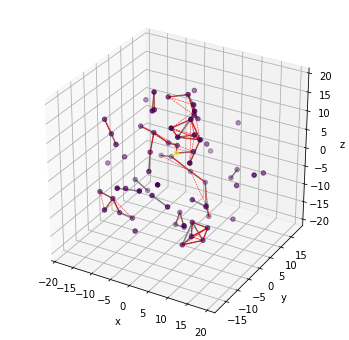

In [12]:
# add 3D axis
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# We want to visualize the smaller bath
data = mock.bath

# First plot the positions of the bath 
colors = np.abs(data.A[:,2,2]/data.A[:,2,2].max())
ax.scatter3D(data.x, data.y, data.z, c=colors, cmap='viridis');
# Plot all pairs of nuclear spins, which are contained
# in the calc.clusters dictionary under they key 2
for c in mock.clusters[2]:
    ax.plot3D(data.x[c], data.y[c], data.z[c], color='grey')
# Plot all triplets of nuclear spins, which are contained
# in the calc.clusters dictionary under they key 3
for c in mock.clusters[3]:
    ax.plot3D(data.x[c], data.y[c], data.z[c], color='red', ls='--', lw=0.5)

ax.set(xlabel='x', ylabel='y', zlabel='z');

Now we setup `Simulator` object for actual simulation.

In [13]:
# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 8  # in A
# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]
# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz

The code already knows the most isotopes, however user can provide their own by providing `types` keyword argument of `Simulator.read_bath` method. The way to initiallize `SpinType` objects is the same as in for `SpinDict` above.

In [14]:
# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]

### Setting the `Simulator` object
All of the kwargs can be provided at the moment of creation. If all of the kwargs are provided, several methods of `Simulator` class are called:

* `Simulator.read_bath`;
* `Simulator.generate_clusters`.

The details are available in the `Simulator` methods description.

In [15]:
# Setting the runner engine
calc = pc.Simulator(spin=1, position=position,
                    alpha=alpha, beta=beta,
                    types=spin_types, D=D, E=E,
                    bath=atoms, r_bath=r_bath,
                    r_dipole=r_dipole, order=order)

Taking advantage of subclassing `np.ndarray` we can change *in situ* the quadrupole tensor of Nitrogen nuclear spin.

In [16]:
nspin = calc.bath
# Set model quadrupole tensor at N atom
quad = np.asarray([[-2.5, 0, 0],
                   [0, -2.5, 0],
                   [0, 0,  5.0]]) * 1e3 * 2 * np.pi

nspin['Q'][nspin['N'] == '14N'] = quad

### Compute coherence function with conventional CCE

In conventional CCE method the Hamiltonian is projected on the qubit levels, and the coherence is computed from the overlap of evolution of the bath, entangled with two different qubit states.

The conventional CCE requires one argument:

* `timespace` — time points at which compute the coherence function.

Additionally, one can provide the following arguments now, instead of in the process of initiallizing ``Simulator`` object:

* `pulses` — number of pulses in CPMG sequence (0 - FID, 1 - HE etc., default 0).
* `mangetic_field` — array of the magnetic field, default (0, 0, 0).

For details see `help(calc.cce_coherence)`.

In [17]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
N = 1
# Mag. Field (Bx By Bz)
B = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=N, magnetic_field=B, 
                      method='cce', quantity='coherence', as_delay=False)

In [18]:
%%timeit
calc.compute(time_space, pulses=N, magnetic_field=B,
             method='cce', quantity='coherence', as_delay=False)

1.44 s ± 6.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Generalized CCE (gCCE)

In contrast, in generalized CCE each cluster includes the central spin explicitly.

Generalized CCE can take `pulses` agrument as an actual pulse sequence with a list of tuples. In each tuple first entry axis, second entry - rotational angle. Otherwise number is also accepted.

For details see `help(calc.gcce_dm)`.

In [19]:
# Hahn-echo pulse sequence
pulse_sequence = [('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=B,
                             pulses=pulse_sequence, mean_field=False,
                             method='gcce', quantity='coherence')

In [20]:
%%timeit
calc.compute(time_space, magnetic_field=B,
             pulses=pulse_sequence, D=D, E=E,
             method='gcce', mean_field=False,
             quantity='coherence')

4.06 s ± 8.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### gCCE with random sampling of bath states

This approach conducts generalized CCE calculations for set of random bath states. Can be turn on by by setting keyword argument `nbstates` to a number of bath states to sample over. Recommended number of bath states is above 100, but the convergence should be checked for each system. Note, that this computation is roughly `nbstates` times longer than generalized CCE, as it computes everything `nbstates` times.

For details see `help(calc.gcce_dm)`.

In [21]:
# Number of random bath states to sample over
n_bath_states = 20

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=B,
                      pulses=pulse_sequence, mean_field=True,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence', seed=seed)

In [22]:
%%timeit
n_bath_states = 5
calc.compute(time_space, magnetic_field=B,
             pulses=pulse_sequence, mean_field=True,
             nbstates=n_bath_states,
             method='gcce', quantity='coherence', seed=seed)

22.9 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Look at all and check that they produce similar results. Note gCCE deviates from other results as number of states is not enough to converge.

Text(0, 0.5, 'Coherence')

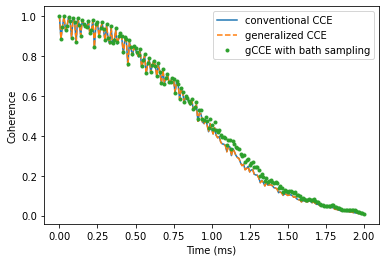

In [23]:
plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')

### Convergence parameters
Having confirmed that all methods produce the same results, we check convergence of conventional CCE with respect to `order`, `r_bath`, `r_dipole` parameters of the `Simulator` object.

First, define all of the parameters.

In [24]:
parameters = dict(
    order=2, # CCE order
    r_bath=40,  # Size of the bath in A
    r_dipole=8,  # Cutoff of pairwise clusters in A
    position=[0, 0, 0], # Position of central Spin
    alpha=[0, 0, 1],
    beta=[0, 1, 0],
    pulses = 1, # N pulses in CPMG sequence
    magnetic_field=[0,0,500]
) # Qubit levels)

time_space = np.linspace(0, 2, 201)  # Time points in ms

We can define a little helper function to streamline the process. Note that resetting the parameters automatically recomputes properties of the bath.

In [25]:
def runner(variable, values):
    invalue = parameters[variable]
    calc = pc.Simulator(spin=1, bath=atoms, **parameters)
    ls = []

    for v in values:
        setattr(calc, variable, v)
        l = calc.compute(time_space, method='cce',
                         quantity='coherence')

        ls.append(l.real)

    parameters[variable] = invalue
    ls = pd.DataFrame(ls, columns=time_space, index=values).T
    return ls

Now we can compute the coherence function at different values of the parameters:

In [26]:
orders = runner('order', [1, 2, 3, 4])
rbs = runner('r_bath', [20, 30, 40, 50, 60])
rds = runner('r_dipole', [4, 6, 8, 10])

We can visualize the convergence of coherence function with respect to different parameters:

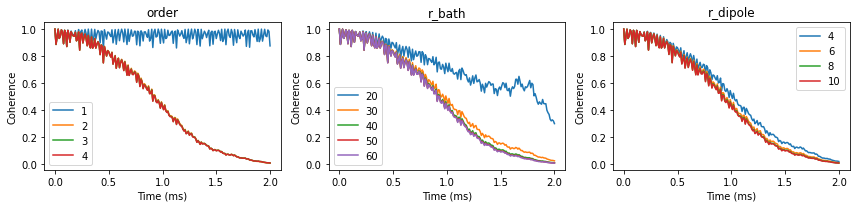

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
orders.plot(ax=axes[0], title='order')
rbs.plot(ax=axes[1], title='r_bath')
rds.plot(ax=axes[2], title='r_dipole')
for ax in axes:
    ax.set(xlabel='Time (ms)', ylabel='Coherence')
fig.tight_layout()